In [146]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [147]:
def read_data(url):
    df = pd.read_csv(url)
    df = df.loc[df[" utilization.gpu [%]"] > 0] #isolating training 
    #print(df.columns)
    return df

In [148]:
def time_duration(df):
    df.timestamp = [datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in df.timestamp]
    time_interval = df.iloc[-1].timestamp - df.iloc[0].timestamp
    #print("Total time in seconds: {}".format(time_interval.total_seconds()))
    return time_interval.total_seconds()

In [151]:
def power_reading(url):
    df = read_data(url)
    time_interval = time_duration(df)
    mean_power =df[' power.draw [W]'].mean()
    total_power = mean_power * time_interval
    gpu_util = df[' utilization.gpu [%]'].mean()
    memory_util = df[' utilization.memory [%]'].mean()
    memory_used = df[' memory.used [MiB]'].mean()
    extract = url.split('/')[1].replace(".","_").split('_')
    data = []
    if (extract[2] != 'pretrain'):
        data = [extract[2], extract[3], extract[4],
                mean_power,time_interval,total_power,gpu_util,memory_util,memory_used]
#     else:
#         data = [extract[2], None, None,
#                 mean_power,time_interval,total_power,gpu_util,memory_util,memory_used]
#     print ("Mean Power consumption (Watt): {}".format(mean_power))
#     print("Total Power consumption (Watt second): {}".format(total_power))
    return df, data

In [153]:
import os
folder_name = 'nvidia'
result = pd.DataFrame(columns=['dataset','batchsize','max_seq_len',
                               'mean_power','total_time','power','gpu_util','memory_util','memory_used'])

for file_name in os.listdir(folder_name):
    #print(file_name)
    url = folder_name + '/' + file_name
    df,data = power_reading(url)
   # print (data)
    if data:
        result =result.append(pd.Series(data, index=result.columns),ignore_index=True)
    #print ("-------------------------------------------")

In [155]:
train_dataset_sizes = {
    'MRPC':3668,
    'CoLA': 8551,
    'SST-2':67349,
    'MNLI':392702,
    'STS-B':8628
}

In [156]:
result['dataset_size'] = result['dataset']
result["dataset_size"].replace(train_dataset_sizes, inplace=True)

In [157]:
result

,dataset,batchsize,max_seq_len,mean_power,total_time,power,gpu_util,memory_util,memory_used,dataset_size
0,SST-2,16,256,211.759289,493.516,104506.597464,93.373841,38.238929,6151.259526,67349
1,MRPC,28,128,204.860397,77.174,15809.896305,91.099338,34.264901,4803.768212,3668
2,MRPC,20,128,193.060506,90.725,17515.414372,90.129213,31.393258,4050.230337,3668
3,CoLA,32,256,227.781566,311.942,71054.637283,95.153344,42.350734,10323.463295,8551
4,MRPC,16,128,166.462923,98.801,16446.703263,90.353846,30.579487,3563.138462,3668
5,MRPC,64,128,223.450000,55.178,12329.524100,97.333333,41.041667,8502.500000,3668
6,MRPC,32,128,199.650667,70.170,14009.487280,92.533333,33.366667,5261.500000,3668
7,MRPC,40,128,215.501631,71.807,15474.525632,92.092199,36.510638,6020.312057,3668
8,CoLA,16,256,211.097671,370.895,78295.070772,93.769863,37.772603,6151.853425,8551
9,MRPC,48,128,222.867895,67.682,15084.144852,93.796992,37.819549,6779.187970,3668


In [158]:
import time
result_file = "results/result"+ str(int(time.time()))
result.to_csv(result_file, index=False)

In [136]:
df_mrpc = result.loc[(result.dataset == 'MRPC') & (result.max_seq_len == '128')]

In [137]:
df_mrpc =df_mrpc.sort_values('batchsize')

In [142]:
df_mrpc

,dataset,batchsize,max_seq_len,mean_power,total_time,power,gpu_util,memory_util,memory_used,dataset_size
4,MRPC,16,128,166.462923,98.801,16446.703263,90.353846,30.579487,3563.138462,3668
2,MRPC,20,128,193.060506,90.725,17515.414372,90.129213,31.393258,4050.230337,3668
18,MRPC,24,128,208.408171,83.879,17481.068953,91.000000,33.286585,4435.317073,3668
1,MRPC,28,128,204.860397,77.174,15809.896305,91.099338,34.264901,4803.768212,3668
6,MRPC,32,128,199.650667,70.170,14009.487280,92.533333,33.366667,5261.500000,3668
7,MRPC,40,128,215.501631,71.807,15474.525632,92.092199,36.510638,6020.312057,3668
9,MRPC,48,128,222.867895,67.682,15084.144852,93.796992,37.819549,6779.187970,3668
5,MRPC,64,128,223.450000,55.178,12329.524100,97.333333,41.041667,8502.500000,3668


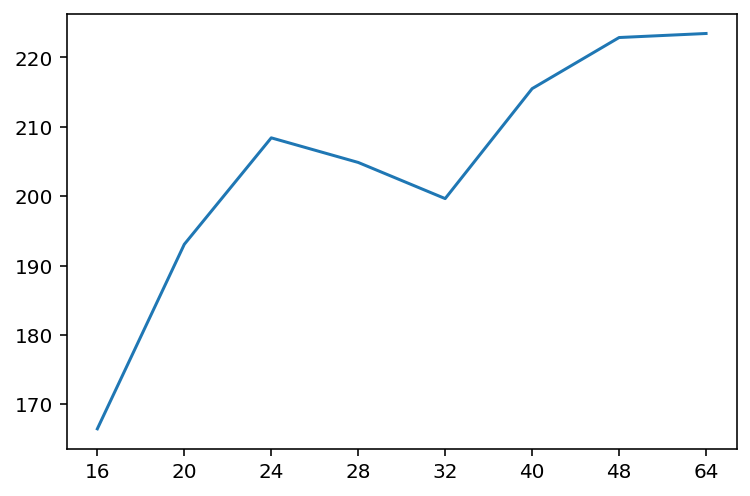

In [138]:
fig, ax = plt.subplots()
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["mean_power"])

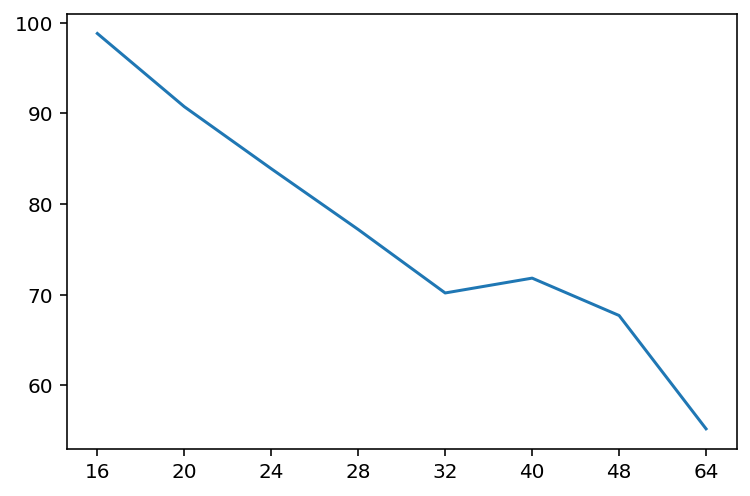

In [139]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["total_time"])

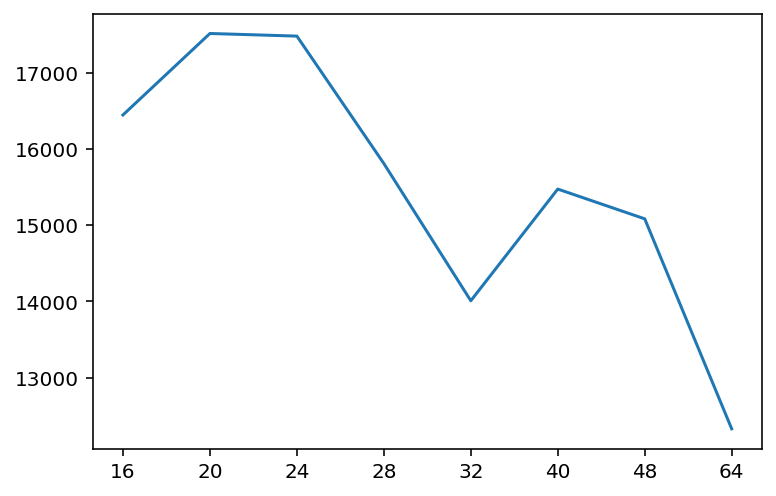

In [140]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["power"])

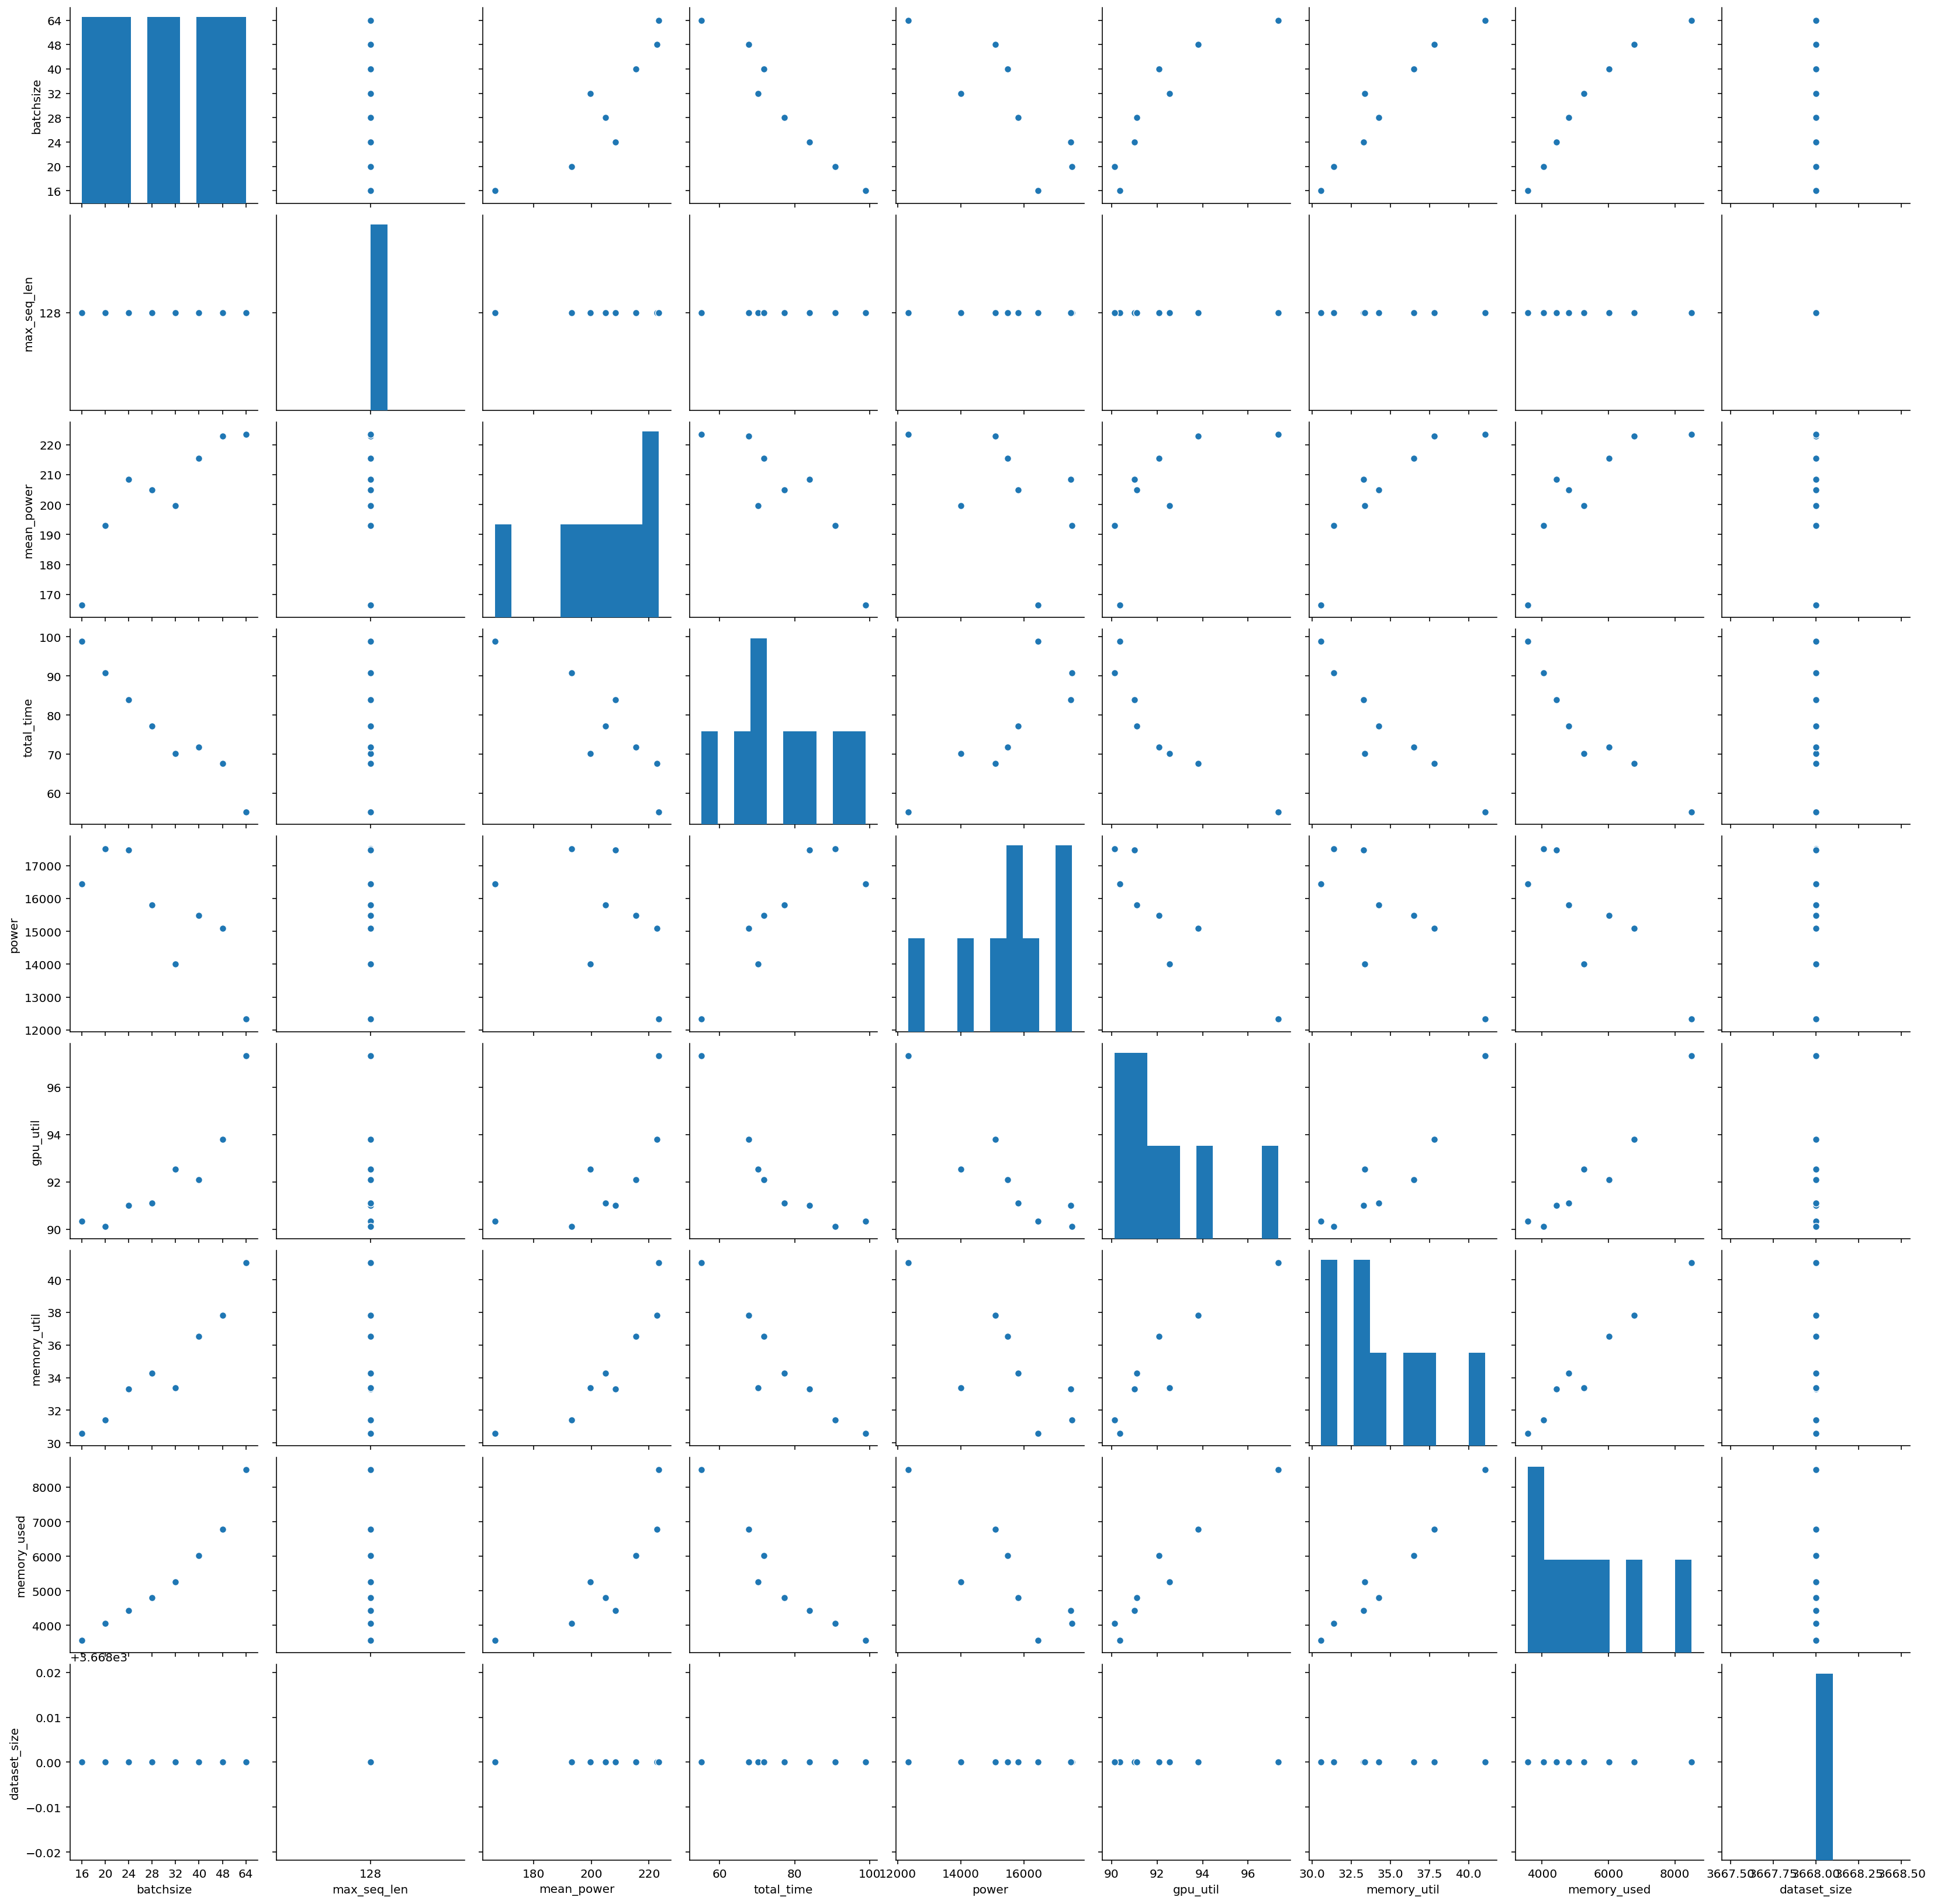

In [141]:
sns.pairplot(df_mrpc)

Increasing batch size leads to less time, better gpu util, more memory used.

Urrgghh but I knew that!


## regression model to check power

In [189]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

In [190]:
features = ['batchsize','max_seq_len', 'total_time','gpu_util','memory_util','memory_used','dataset_size']
X = result[features]
y = result['mean_power']

In [191]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1) #test_size=0.25

In [192]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)

RandomForestRegressor(random_state=1)

In [193]:
new_preds = forest_model.predict(val_X)
print("Random forest mae:",mean_absolute_error(val_y, new_preds))
print("Random forest rmse:",sqrt(mean_squared_error(val_y, new_preds)))
print("Random forest R^2 score:", forest_model.score(val_X, val_y)) #coefficient of determination R^2 of the prediction

Random forest mae: 6.373425229025074
Random forest rmse: 7.258827495447765
Random forest R^2 score: 0.6886883118679927


In [194]:
def feature_imp(model, train_X):
    feature_importances = pd.DataFrame(model.feature_importances_,
    index = train_X.columns,
    columns=['importance']).sort_values('importance', ascending=False)
    sns.barplot(data=feature_importances.reset_index(),x='importance',y='index',orient='h')

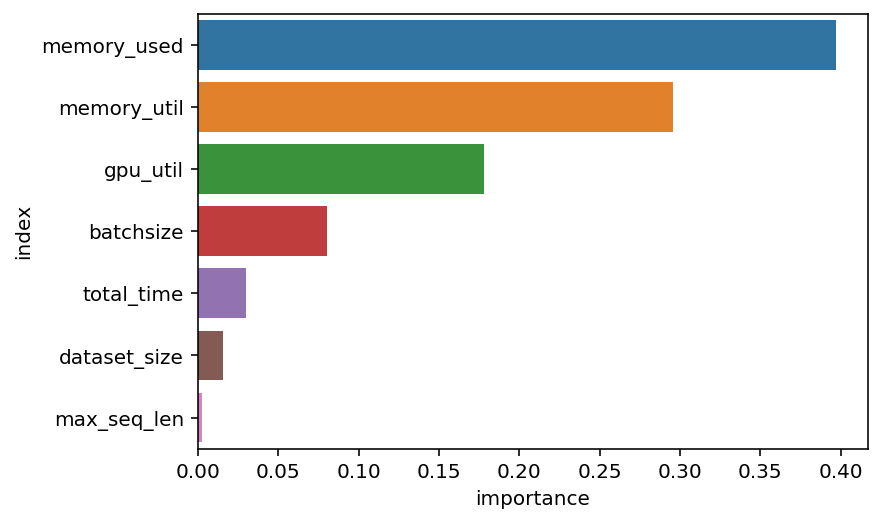

In [195]:
feature_imp(forest_model,train_X)

In [ ]:
#try k-fold
#add more data
# get flops, model size

In [43]:
url = 'nvidia/nvidia_power_CoLA_32_128.csv'
df, x= power_reading(url)

In [44]:
df.columns

Index(['timestamp', ' utilization.gpu [%]', ' utilization.memory [%]',
       ' memory.total [MiB]', ' memory.used [MiB]', ' memory.free [MiB]',
       ' temperature.gpu', ' power.draw [W]', ' pstate'],
      dtype='object')

In [119]:
#sns.pairplot(df)